# Zadanie 1
## Generowanie danych i funkcje pomocnicze

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np

def train_single_trees(X_train, y_train, n_trees=10):
    trees = []
    for i in range(n_trees):
        tree = DecisionTreeClassifier(random_state=i)
        tree.fit(X_train, y_train)
        trees.append(tree)
    return trees

def calculate_prediction_variance(trees, X):
    pred_probas = []
    for tree in trees:
        proba = tree.predict_proba(X)[:, 1]
        pred_probas.append(proba)
    pred_probas = np.array(pred_probas)
    variances = np.var(pred_probas, axis=0)
    return variances, pred_probas

def bootstrap_sample(X, y, random_state=None):
    """
    Losujemy n próbek ze zwracaniem
    oob indices - te które nie zostały wybrane przez losowanie ze zwracaniem - potencjalny zbiór walidacyjny
    """
    rng = np.random.RandomState(random_state)
    n = len(X)
    indices = rng.choice(n, size=n, replace=True)
    oob_indices = list(set(range(n)) - set(indices))
    return X[indices], y[indices], oob_indices

def majority_voting(trees, X):
    all_preds = []
    for tree in trees:
        all_preds.append(tree.predict(X))
    all_preds = np.array(all_preds)
    return np.array([np.bincount(all_preds[:, i]).argmax() for i in range(all_preds.shape[1])])

def generate_credit_data(n_samples=1000, n_features=10, random_state=42):
    X, y = make_classification(
        n_samples=n_samples,      
        n_features=n_features,       
        n_informative=6,     
        n_redundant=2,       
        n_clusters_per_class=2,
        random_state=random_state
    )
    return X, y

X, y = generate_credit_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


## a) Niestabilność pojedynczego drzewa

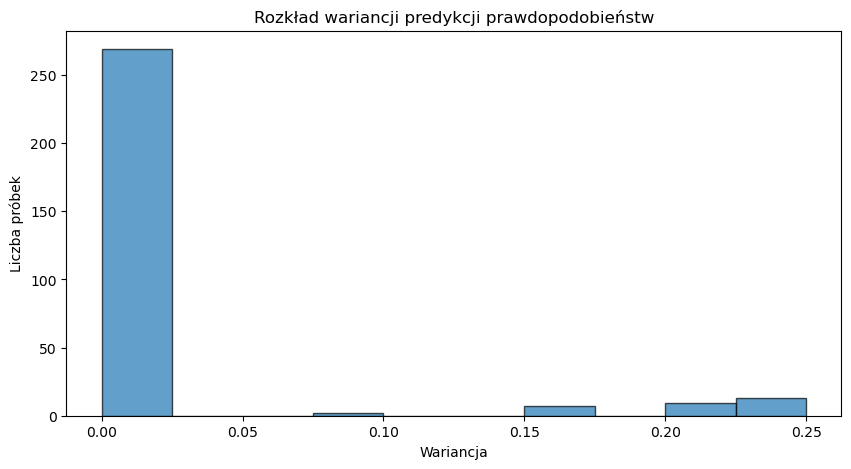

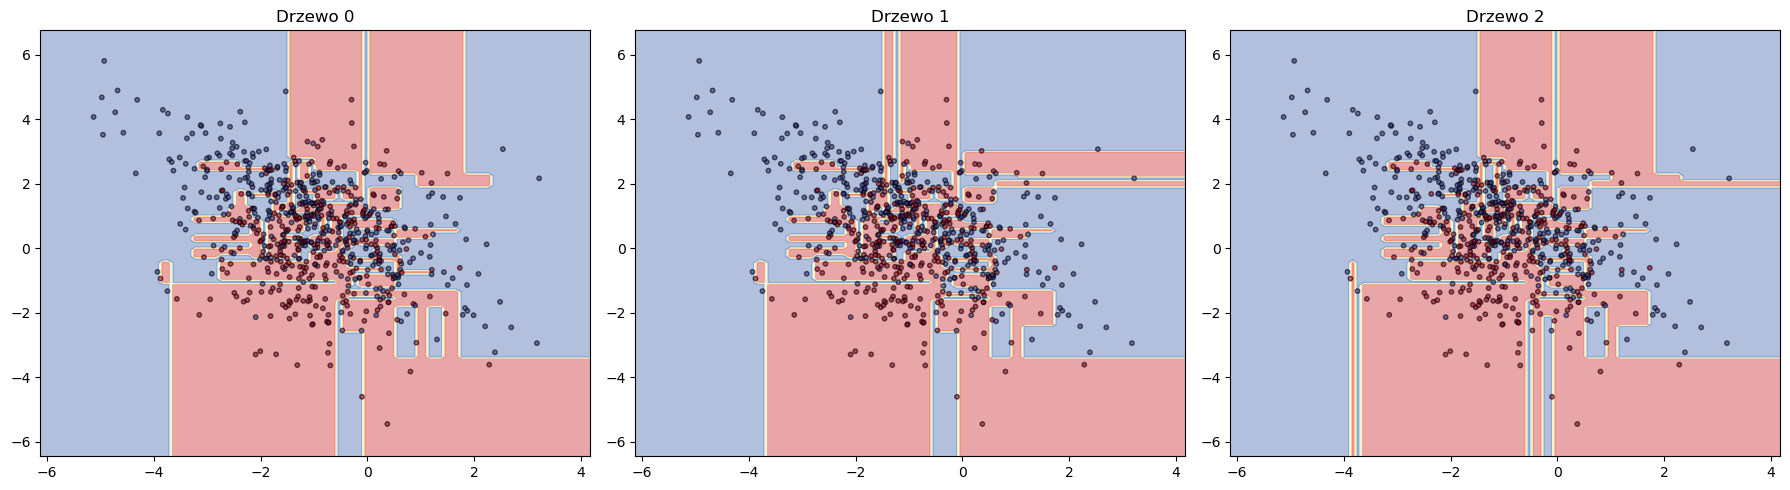

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

n_trees = 10

variances, _ = calculate_prediction_variance(train_single_trees(X_train, y_train), X_test)

plt.figure(figsize=(10,5))
plt.hist(variances, bins=10, edgecolor='black', alpha=0.7)
plt.title('Rozkład wariancji predykcji prawdopodobieństw')
plt.xlabel('Wariancja')
plt.ylabel('Liczba próbek')
plt.show()

X_train_2d = X_train[:, :2]
X_test_2d = X_test[:, :2]
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
trees_2d = train_single_trees(X_train_2d, y_train, 3)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.ravel()

for i, tree in enumerate(trees_2d):
    Preds = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Preds = Preds.reshape(xx.shape)
    
    axes[i].contourf(xx, yy, Preds, alpha=0.4, cmap=plt.cm.RdYlBu)
    
    axes[i].scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, 
                    s=10, edgecolor='k', cmap=plt.cm.RdYlBu, alpha=0.6)

    axes[i].set_title(f"Drzewo {i}")

plt.tight_layout()
plt.show()



## b) Agregacja Predykcji (Bootstrap Aggregating)

In [4]:
from sklearn.metrics import accuracy_score


n_bootstrap_trees = 50
bootstrap_trees = []
bagging_preds = []
fores = []

for f in range(10):
    # tworze 10 lasów aby zrobić bagging i sprawdzić wariancję 
    oob_scores = []
    rng = np.random.RandomState(f)
    for t in range(n_bootstrap_trees):
        seed = rng.randint(0, 1000)
        X_boot, y_boot, oob_idx = bootstrap_sample(X_train, y_train, random_state=seed)
        tree = DecisionTreeClassifier(random_state=i)
        tree.fit(X_boot, y_boot)
        bootstrap_trees.append(tree)

        if len(oob_idx) > 0:
            X_oob = X[oob_idx]
            y_oob = y[oob_idx]
            oob_accuracy = tree.score(X_oob, y_oob)
            oob_scores.append(oob_accuracy)
    
    print(f"Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.{f} wynosi: {np.mean(oob_scores)} ")

    y_pred_bootstrap = majority_voting(bootstrap_trees, X_test)
    bagging_preds.append(y_pred_bootstrap)

bagging_preds = np.array(bagging_preds)
bagging_variance = np.var(bagging_preds, axis=0)
print("=" * 50)
print(f"Średnia wariancja w baggingu, dla 10 lasów po 50 drzew: {np.mean(bagging_variance)}")
print(f"Średnia wariancja klasycznie, czyli dla 10 drzew: {np.mean(variances)}")



Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.0 wynosi: 0.8995898948300329 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.1 wynosi: 0.9064347981450321 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.2 wynosi: 0.9022608685065779 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.3 wynosi: 0.9071619671485442 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.4 wynosi: 0.90683630733204 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.5 wynosi: 0.9016643223963701 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.6 wynosi: 0.9001056924105056 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.7 wynosi: 0.9010064892768184 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.8 wynosi: 0.8972504144842667 
Średnia dokładność na zbiorze OOB walidacyjnym lasu nr.9 wynosi: 0.8998740596229287 
Średnia wariancja w baggingu, dla 10 lasów po 50 drzew: 0.0047
Średnia wariancja klasycznie, czyli dla 10 drzew: 0.021133333333333337


## c) Losowe podzbiory cech:


Statystyki wariancji dla drzew Z losowaniem cech:
  Średnia wariancja: 0.102131
  Std wariancji: 0.084208
  Min wariancja: 0.000000
  Max wariancja: 0.250000

Statystyki wariancji dla drzew BEZ losowania cech:
  Średnia wariancja: 0.022655
  Std wariancji: 0.065920
  Min wariancja: 0.000000
  Max wariancja: 0.249600


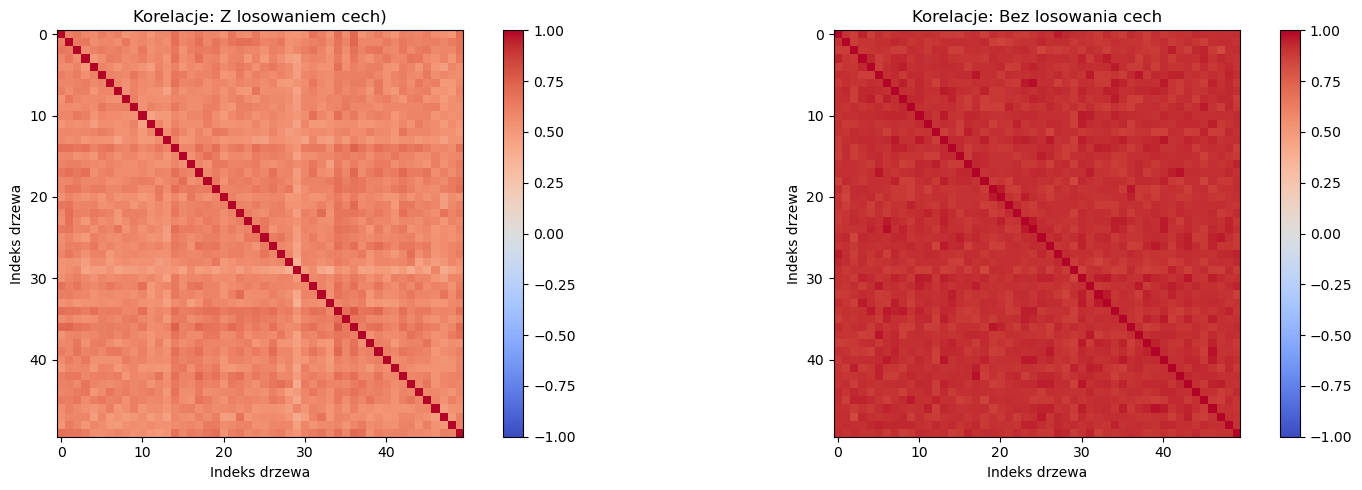

In [5]:
from scipy.stats import pearsonr

def build_randomized_tree(X_train, y_train, random_state, max_features='sqrt'):
    n_features = X.shape[1]
    if max_features == 'sqrt':
        max_features_param = int(np.round(np.sqrt(n_features)))
    else:
        max_features_param = None # wszystkie cechy
    
    tree = DecisionTreeClassifier(random_state=random_state, max_features=max_features_param)
    tree.fit(X_train, y_train)
    return tree

n_trees = 50
trees_with_feature_sampling = []
trees_without_feature_sampling = []

for i in range(n_trees):
    # Drzewo z losowaniem cech
    tree_with_sampling = build_randomized_tree(X_train, y_train, random_state=i, max_features='sqrt')
    # tree_with_sampling.fit(X_train, y_train)
    trees_with_feature_sampling.append(tree_with_sampling)
    
    # Drzewo bez losowania cech
    tree_without_sampling = build_randomized_tree(X_train, y_train, random_state=i, max_features=None)
    # tree_without_sampling.fit(X_train, y_train)
    trees_without_feature_sampling.append(tree_without_sampling)

var_with_sampling, preds_with_sampling = calculate_prediction_variance(trees_with_feature_sampling, X_test)
var_without_sampling, preds_without_sampling = calculate_prediction_variance(trees_without_feature_sampling, X_test)

print("\nStatystyki wariancji dla drzew Z losowaniem cech:")
print(f"  Średnia wariancja: {np.mean(var_with_sampling):.6f}")
print(f"  Std wariancji: {np.std(var_with_sampling):.6f}")
print(f"  Min wariancja: {np.min(var_with_sampling):.6f}")
print(f"  Max wariancja: {np.max(var_with_sampling):.6f}")

print("\nStatystyki wariancji dla drzew BEZ losowania cech:")
print(f"  Średnia wariancja: {np.mean(var_without_sampling):.6f}")
print(f"  Std wariancji: {np.std(var_without_sampling):.6f}")
print(f"  Min wariancja: {np.min(var_without_sampling):.6f}")
print(f"  Max wariancja: {np.max(var_without_sampling):.6f}")

def calculate_correlation_matrix(prediction_matrix):
    """
    Oblicza macierz korelacji Pearsona między predykcjami drzew
    prediction_matrix: macierz kształtu (n_trees, n_samples)
    """
    n_trees = prediction_matrix.shape[0]
    corr_matrix = np.zeros((n_trees, n_trees))
    
    for i in range(n_trees):
        for j in range(n_trees):
            if i == j:
                corr_matrix[i, j] = 1.0
            else:
                corr_matrix[i, j], _ = pearsonr(prediction_matrix[i], prediction_matrix[j])
    
    return corr_matrix

corr_with_sampling = calculate_correlation_matrix(preds_with_sampling)
corr_without_sampling = calculate_correlation_matrix(preds_without_sampling)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Macierz korelacji - z losowaniem cech
im1 = axes[0].imshow(corr_with_sampling, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Korelacje: Z losowaniem cech)')
axes[0].set_xlabel('Indeks drzewa')
axes[0].set_ylabel('Indeks drzewa')
plt.colorbar(im1, ax=axes[0])

# Macierz korelacji - bez losowania cech
im2 = axes[1].imshow(corr_without_sampling, cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Korelacje: Bez losowania cech')
axes[1].set_xlabel('Indeks drzewa')
axes[1].set_ylabel('Indeks drzewa')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


## d) Analiza końcowa

In [6]:
from sklearn.ensemble import RandomForestClassifier

def calculate_ensemble_metrics(trees, X_test, y_test):
    # Głosowanie większościowe
    y_pred = majority_voting(trees, X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Wariancja predykcji prawdopodobieństw
    pred_probas = np.array([tree.predict_proba(X_test)[:, 1] for tree in trees])
    variances = np.var(pred_probas, axis=0)
    mean_variance = np.mean(variances)
    
    # Średnia dokładność pojedynczych drzew
    tree_accuracies = [tree.score(X_test, y_test) for tree in trees]
    mean_tree_accuracy = np.mean(tree_accuracies)
    
    # Korelacja między drzewami
    n_trees = len(trees)
    correlations = []
    for i in range(n_trees):
        for j in range(i+1, n_trees):
            corr, _ = pearsonr(pred_probas[i], pred_probas[j])
            correlations.append(corr)
    mean_correlation = np.mean(correlations)
    
    
    return {
        'accuracy': accuracy,
        'mean_variance': mean_variance,
        'mean_tree_accuracy': mean_tree_accuracy,
        'mean_correlation': mean_correlation,
        'n_trees': n_trees
    }

tree_counts = [10, 50, 100, 200, 300]
results_with_sampling = {n: [] for n in tree_counts}
results_without_sampling = {n: [] for n in tree_counts}
rf_results = {n: [] for n in tree_counts}  # Dla RandomForest


for n_trees in tree_counts:    
    # Ensemble z losowaniem cech
    trees_with_sampling = []
    for i in range(n_trees):
        X_boot, y_boot, _ = bootstrap_sample(X_train, y_train, random_state=i)
        tree = build_randomized_tree(X_boot, y_boot, random_state=i, max_features='sqrt')
        trees_with_sampling.append(tree)
    
    metrics_with = calculate_ensemble_metrics(trees_with_sampling, X_test, y_test)
    results_with_sampling[n_trees].append(metrics_with)
    
    # Ensemble bez losowania cech
    trees_without_sampling = []
    for i in range(n_trees):
        X_boot, y_boot, _ = bootstrap_sample(X_train, y_train, random_state=i)
        tree = build_randomized_tree(X_boot, y_boot, random_state=i, max_features=None)
        trees_without_sampling.append(tree)
    
    metrics_without = calculate_ensemble_metrics(trees_without_sampling, X_test, y_test)
    results_without_sampling[n_trees].append(metrics_without)
    
    # RandomForest z sklearn
    rf = RandomForestClassifier(
        n_estimators=n_trees,
        max_features='sqrt',
        random_state=i
    )
    rf.fit(X_train, y_train)
    
    # Metryki dla RandomForest
    rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
    
    # Wariancja dla RF (pobieramy prawdopodobieństwa z każdego drzewa)
    rf_pred_probas = np.array([tree.predict_proba(X_test)[:, 1] for tree in rf.estimators_])
    rf_variances = np.var(rf_pred_probas, axis=0)
    rf_mean_variance = np.mean(rf_variances)
    
    # Korelacje dla RF
    rf_correlations = []
    for i in range(len(rf.estimators_)):
        for j in range(i+1, len(rf.estimators_)):
            corr, _ = pearsonr(rf_pred_probas[i], rf_pred_probas[j])
            rf_correlations.append(corr)
    rf_mean_correlation = np.mean(rf_correlations)
    
    rf_metrics = {
        'accuracy': rf_accuracy,
        'mean_variance': rf_mean_variance,
        'mean_correlation': rf_mean_correlation,
        'n_trees': n_trees
    }
    rf_results[n_trees].append(rf_metrics)




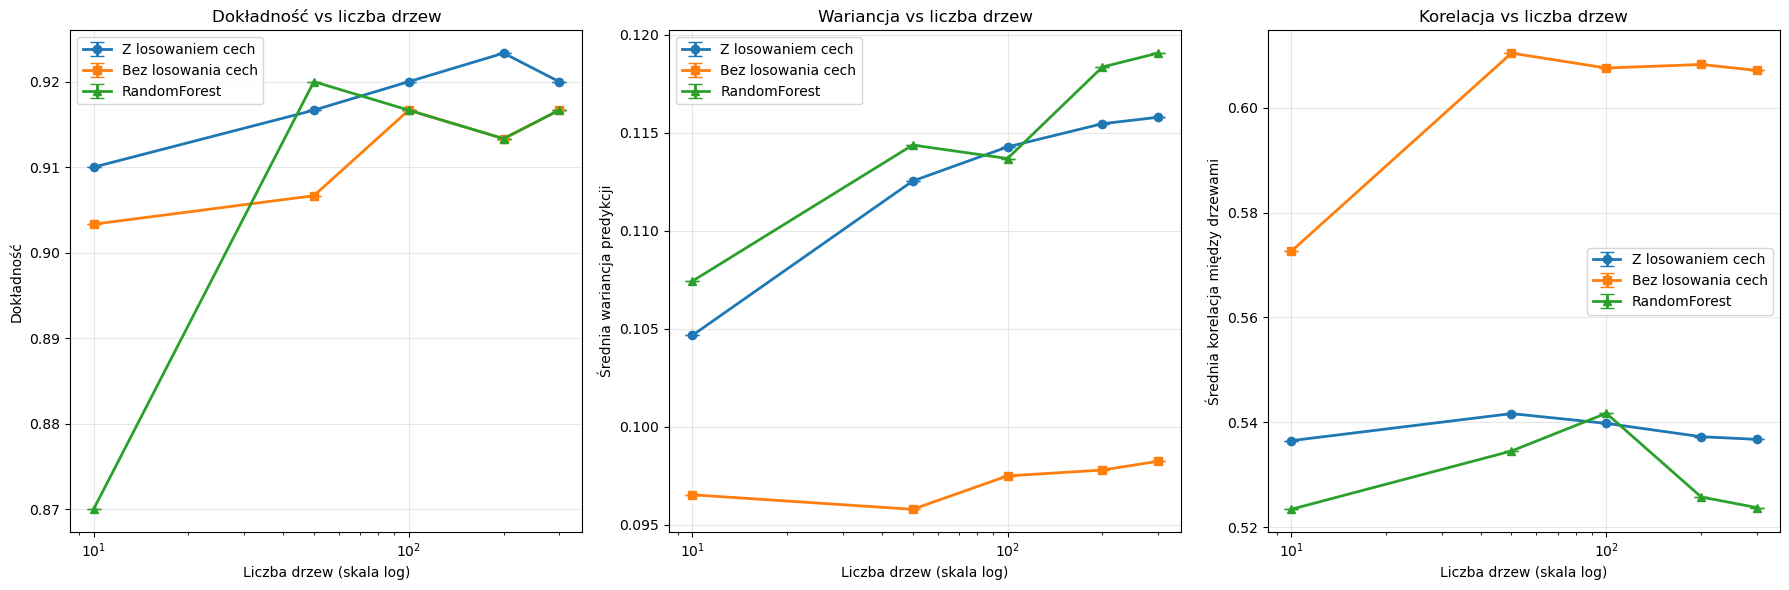

In [7]:
def extract_metric(results_dict, metric_name):
    """Wyciąga wartości metryk z wyników"""
    values = []
    for n in tree_counts:
        # results_dict[n] to lista słowników - bierzemy pierwszy (i jedyny) element
        values.append(results_dict[n][0][metric_name])
    return values

def extract_metric_mean_std(results_dict, metric_name):
    """Wyciąga średnie i odchylenia standardowe """
    means = []
    stds = []
    for n in tree_counts:
        all_values = [result[metric_name] for result in results_dict[n]]
        means.append(np.mean(all_values))
        stds.append(np.std(all_values))
    return means, stds

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

acc_with, acc_with_std = extract_metric_mean_std(results_with_sampling, 'accuracy')
acc_without, acc_without_std = extract_metric_mean_std(results_without_sampling, 'accuracy')
acc_rf, acc_rf_std = extract_metric_mean_std(rf_results, 'accuracy')

axes[0].errorbar(tree_counts, acc_with, yerr=acc_with_std,
                 label='Z losowaniem cech', marker='o', capsize=5, linewidth=2)
axes[0].errorbar(tree_counts, acc_without, yerr=acc_without_std,
                 label='Bez losowania cech', marker='s', capsize=5, linewidth=2)
axes[0].errorbar(tree_counts, acc_rf, yerr=acc_rf_std,
                 label='RandomForest', marker='^', capsize=5, linewidth=2)

axes[0].set_xscale('log')
axes[0].set_xlabel('Liczba drzew (skala log)')
axes[0].set_ylabel('Dokładność')
axes[0].set_title('Dokładność vs liczba drzew')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

var_with, var_with_std = extract_metric_mean_std(results_with_sampling, 'mean_variance')
var_without, var_without_std = extract_metric_mean_std(results_without_sampling, 'mean_variance')
var_rf, var_rf_std = extract_metric_mean_std(rf_results, 'mean_variance')

axes[1].errorbar(tree_counts, var_with, yerr=var_with_std,
                 label='Z losowaniem cech', marker='o', capsize=5, linewidth=2)
axes[1].errorbar(tree_counts, var_without, yerr=var_without_std,
                 label='Bez losowania cech', marker='s', capsize=5, linewidth=2)
axes[1].errorbar(tree_counts, var_rf, yerr=var_rf_std,
                 label='RandomForest', marker='^', capsize=5, linewidth=2)

axes[1].set_xscale('log')
axes[1].set_xlabel('Liczba drzew (skala log)')
axes[1].set_ylabel('Średnia wariancja predykcji')
axes[1].set_title('Wariancja vs liczba drzew')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

corr_with, corr_with_std = extract_metric_mean_std(results_with_sampling, 'mean_correlation')
corr_without, corr_without_std = extract_metric_mean_std(results_without_sampling, 'mean_correlation')
corr_rf, corr_rf_std = extract_metric_mean_std(rf_results, 'mean_correlation')

axes[2].errorbar(tree_counts, corr_with, yerr=corr_with_std,
                 label='Z losowaniem cech', marker='o', capsize=5, linewidth=2)
axes[2].errorbar(tree_counts, corr_without, yerr=corr_without_std,
                 label='Bez losowania cech', marker='s', capsize=5, linewidth=2)
axes[2].errorbar(tree_counts, corr_rf, yerr=corr_rf_std,
                 label='RandomForest', marker='^', capsize=5, linewidth=2)

axes[2].set_xscale('log')
axes[2].set_xlabel('Liczba drzew (skala log)')
axes[2].set_ylabel('Średnia korelacja między drzewami')
axes[2].set_title('Korelacja vs liczba drzew')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
